In [1]:
import cv2

import os
import sys
import numpy as np
import aruco
from matplotlib import pyplot as plt
sys.path.append('..')
from utils import * # Please note that many of the function used in the notebook are located in the utils

In [2]:
# Constants declaration

# Camera configuration
camera_config = "../arucoConfig/baumer12mm1mf.yml"
camparam = aruco.CameraParameters()
camparam.readFromXMLFile(camera_config)

# Configuration of the boxes and creation of marker maps
lower_box_config = "../arucoConfig/block1(lowest).yml"
higher_box_config = "../arucoConfig/block2(highest).yml"
mmap_lowest = aruco.MarkerMap(lower_box_config)
mmap_highest = aruco.MarkerMap(higher_box_config)

# Example videos
video_example1 = "../Data/baumer_video0043.avi"
video_example2 = "../Data/baumer_video0050.avi"

## How markers are located

detected ids: 7, 15, 19, 21, 24


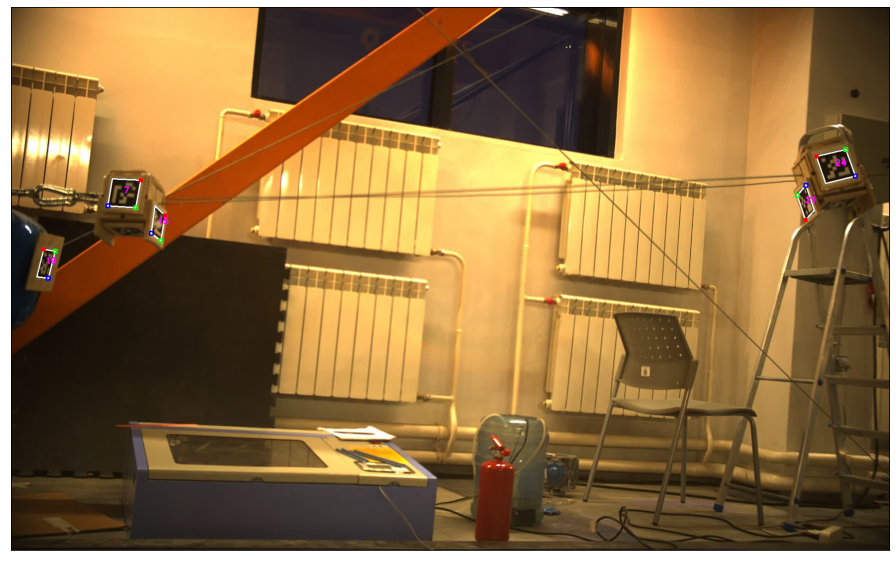

In [3]:
# Open video with cv2
cap = cv2.VideoCapture(video_example1)
ret, frame = cap.read() # Take first frame

# Init detector and get markers
detector = aruco.MarkerDetector()
markers = detector.detect(frame)
print("detected ids: {}".format(", ".join(str(m.id) for m in markers)))

for marker in markers:
    marker.draw(frame, np.array([255, 255, 255]), 2)
    aruco.CvDrawingUtils.draw3dAxis(frame, camparam, marker.Rvec, marker.Tvec, .1)

plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.show()

## How the markermap location looks like

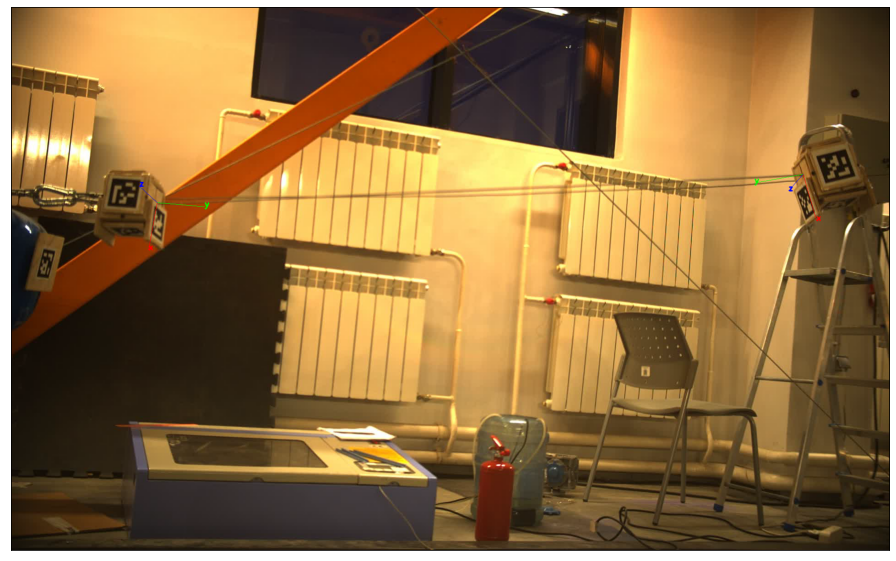

In [4]:
# Take first picture from the video
cap = cv2.VideoCapture(video_example1)
ret, frame = cap.read()

# Init detector and marker map pose trackers
detector, mmap_low_p, mmap_high_p = get_new_MM_posers(camparam, mmap_lowest, mmap_highest)

markers = detector.detect(frame)


mmap_low_p.estimatePose(markers), mmap_high_p.estimatePose(markers)

if mmap_low_p.isValid():
    aruco.CvDrawingUtils.draw3dAxis(frame, camparam, mmap_low_p.getRvec(), tune_tvector(mmap_low_p, True), .1)
if mmap_high_p.isValid():
    aruco.CvDrawingUtils.draw3dAxis(frame, camparam, mmap_high_p.getRvec(), tune_tvector(mmap_high_p, False), .1)


plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.show()

In [5]:
cap = cv2.VideoCapture(video_example2)
ret, frame = cap.read()

# Try to find a picture with at least 4 markers, marker map would fail otherwise
while ret:
    detector = aruco.MarkerDetector()
    markers = detector.detect(frame)
    if len(markers) == 4:
        break
    ret, frame = cap.read()

## Check how marker map look in another setting

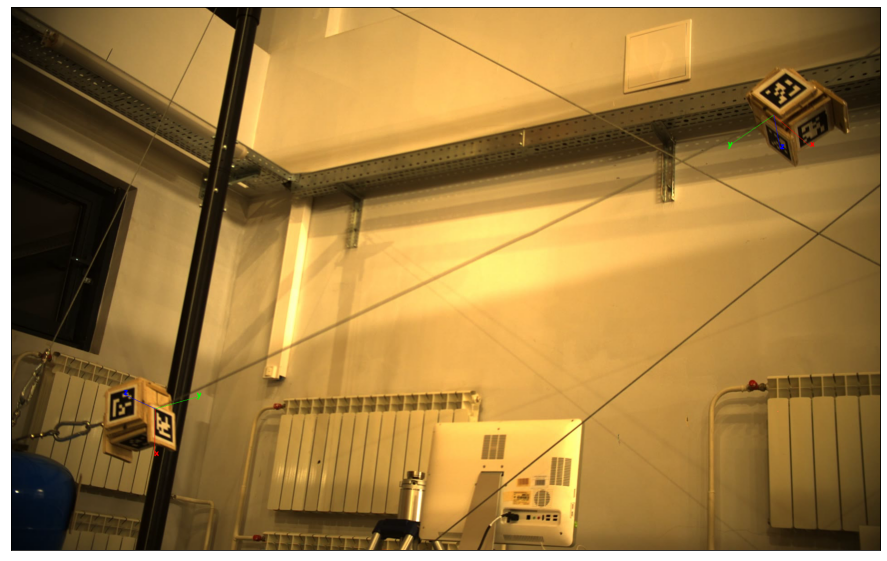

In [6]:
frame_copy = frame.copy()
detector, mmap_low_p, mmap_high_p = get_new_MM_posers(camparam, mmap_lowest, mmap_highest)

markers = detector.detect(frame)
mmap_low_p.estimatePose(markers), mmap_high_p.estimatePose(markers)

if mmap_low_p.isValid():
    aruco.CvDrawingUtils.draw3dAxis(frame_copy, camparam, mmap_low_p.getRvec(), tune_tvector(mmap_low_p, True), .1)
if mmap_high_p.isValid():
    aruco.CvDrawingUtils.draw3dAxis(frame_copy, camparam, mmap_high_p.getRvec(), tune_tvector(mmap_high_p, False), .1)
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(frame_copy, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.show()

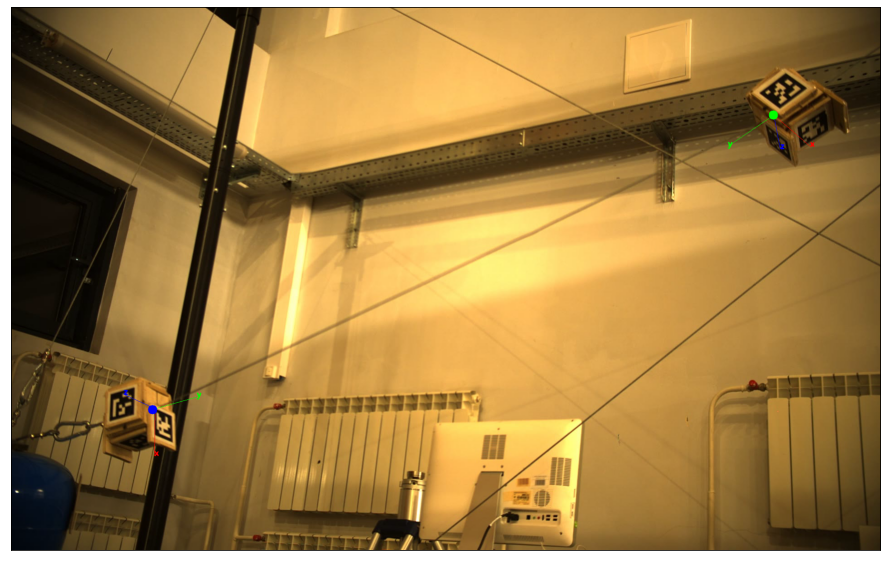

In [7]:
x, y = get_2d_points(camparam.CameraMatrix, tune_tvector(mmap_low_p, True), mmap_low_p.getRvec())
x2, y2 = get_2d_points(camparam.CameraMatrix, tune_tvector(mmap_high_p, False), mmap_high_p.getRvec())

img_circles = cv2.circle(frame_copy.copy(),(x,y), 10, [255,0,0], cv2.FILLED)
img_circles = cv2.circle(img_circles, (x2,y2), 10, [0,255,0], cv2.FILLED)

plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(img_circles, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.show()

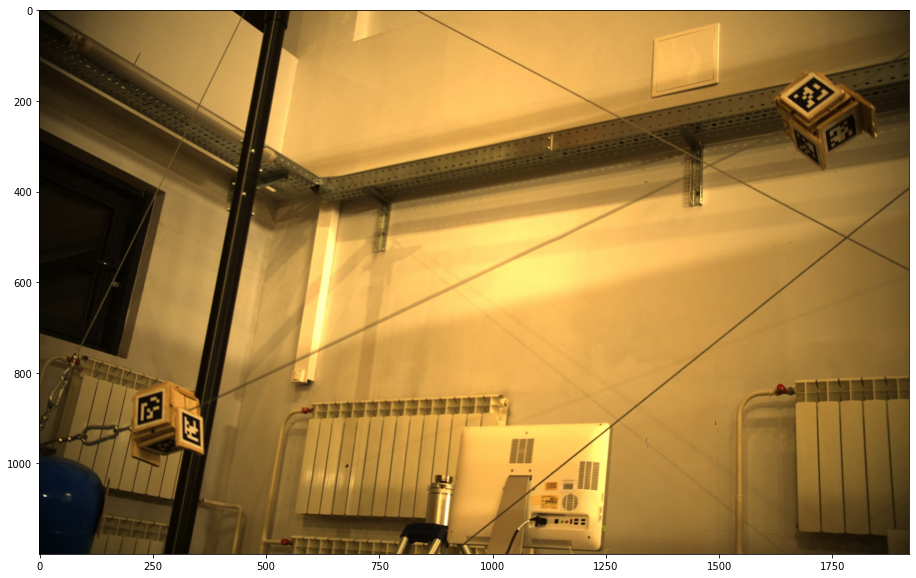

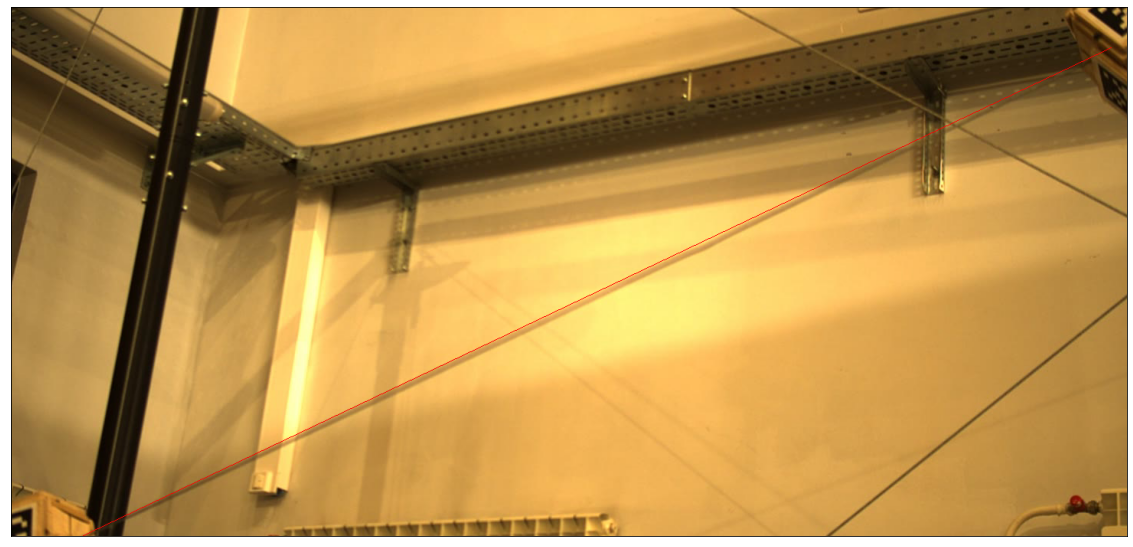

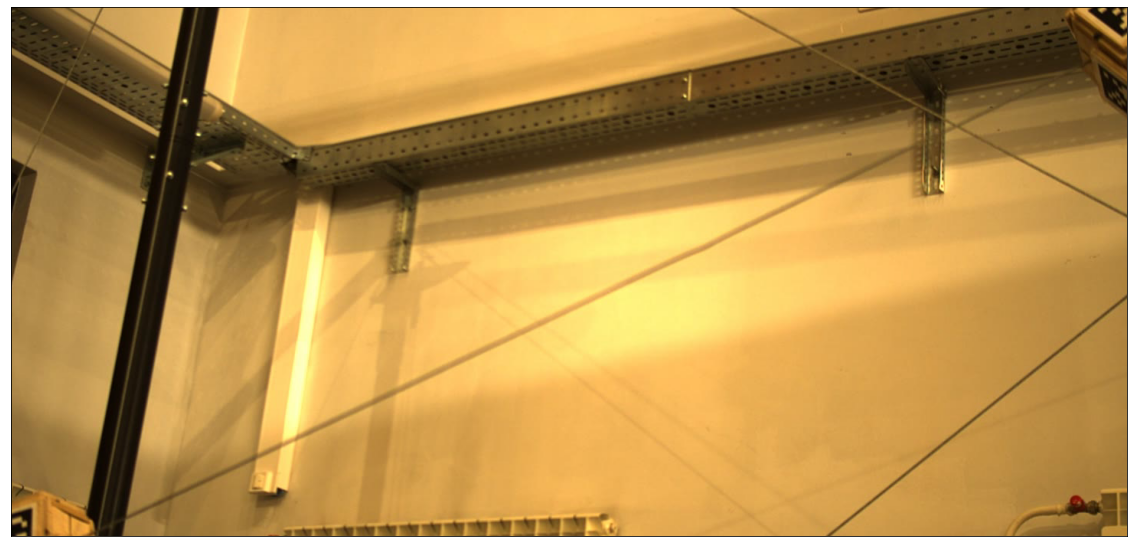

In [8]:
# Take the middle of the face markers for lower and upper box
lower_marker = None
upper_marker = None
for marker in markers:
    if marker.id == 24:
        upper_marker = marker
    if marker.id == 7:
        lower_marker = marker
        
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.show()

# We will cut other parts of the image besides those boxes
min_h, max_h, min_w, max_w = get_heights_width_markers(lower_marker, upper_marker)

# Crop the image, draw a line from the centers of both boxes
cropped = frame[min_w:max_w, min_h:max_h]

line_p1 = (max(x-min_h,0), max(y-min_w,0))
line_p2 = (max(x2-min_h,0), max(y2-min_w,0))
cropped_with_line = cv2.line(cropped.copy(),
                             line_p1,
                             line_p2,
                             [0,0,255], 1)

plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(cropped_with_line, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.show()

img_converted = cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,10))
plt.imshow(img_converted)
plt.xticks([]), plt.yticks([])
plt.show()

## Locating the wire

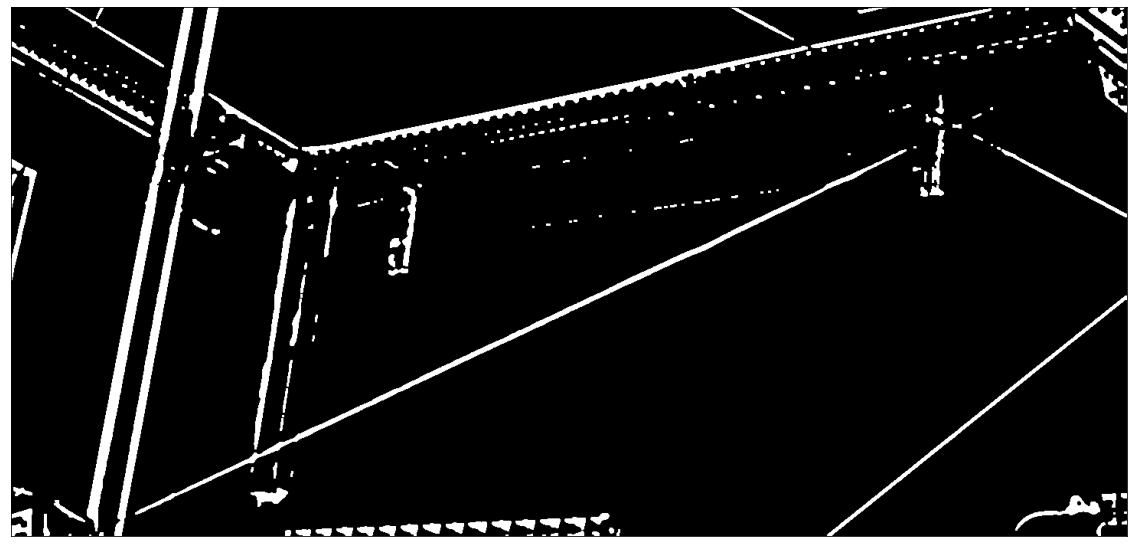

In [9]:
grayed = search_for_line(cropped)
plt.figure(figsize=(20,10))
plt.imshow(grayed, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

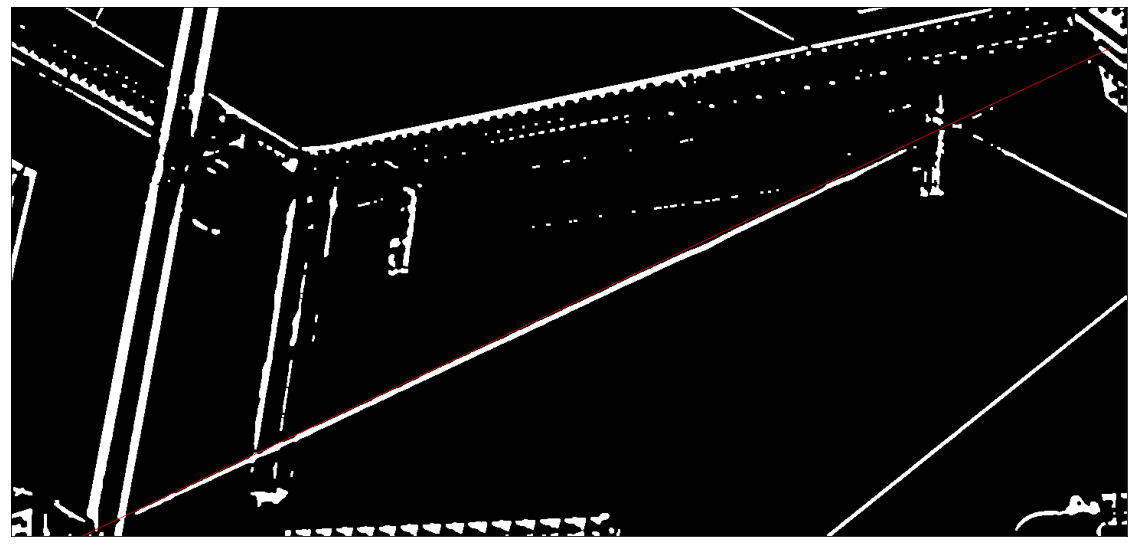

In [10]:
# Red wire represents the perfect location of the cable
grayed_with_line = cv2.cvtColor(grayed, cv2.COLOR_GRAY2RGB)
grayed_with_line = cv2.line(grayed_with_line,
                             line_p1,
                             line_p2,
                             [255,0,0], 1)
plt.figure(figsize=(20,10))
plt.imshow(grayed_with_line)
plt.xticks([]), plt.yticks([])
plt.show()

In [11]:
rays = []
middle_point = int((line_p1[1]+line_p2[1])/2), int((line_p2[0]+line_p1[0])/2) # Middle point of the red line
current_ray = Ray()

# Send a ray down to the bottom of the picture and locate any white pixels in a row
while middle_point[0] != grayed.shape[0]:
    # If white pixel found - add it to the current ray
    if np.all(grayed[middle_point] == [255,255,255]):
        current_ray.add_point(middle_point)
    # else, create a new one if previous one size wasn't 0
    elif current_ray.width != 0:
        rays.append(current_ray)
        current_ray = Ray()
    # Proceed with the iteration
    middle_point = (middle_point[0]+1, middle_point[1]) 

## The distance between our cable and the perfect one

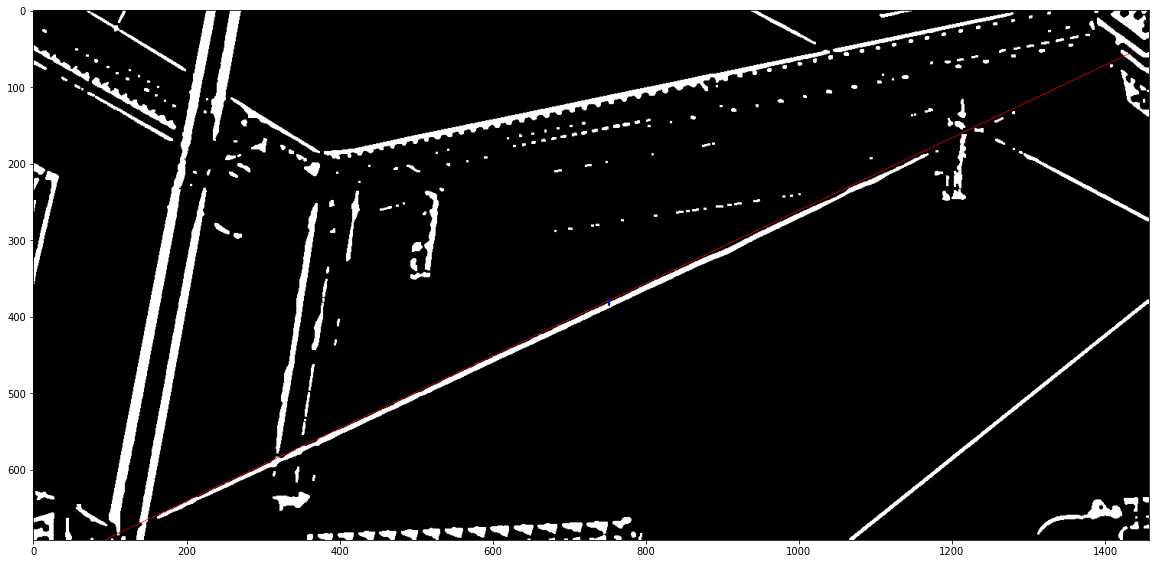

The difference is ~6 pixels


In [12]:
start = int((line_p2[0]+line_p1[0])/2), int((line_p1[1]+line_p2[1])/2)
end = rays[0].get_middle()
grayed_with_two_lines = cv2.line(grayed_with_line.copy(), start, end, [0,0,255], 2)

plt.figure(figsize=(20,10))
plt.imshow(grayed_with_two_lines)

plt.show()
print(f"The difference is ~{end[1] - start[1]} pixels")